<h2> BIBLIOTECAS USADAS

In [1]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from collections import Counter

<h3> configuração de AG

In [2]:
# --- Parâmetros AG ---
NUM_INDIVIDUOS = 40
NUM_GERACOES = 500
# TAMANHO_GENE = 3
TAXA_MUTACAO_INICIAL = 0.7
NUM_PARTIDAS_SIM = 20  # Partidas jogadas para avaliar cada gene/indivíduo
TAXA_CROSSOVER_INICIAL = 0.7  # recombinação muito alta no início, vai decaindo a cada geração
ELITE = 6  # Número de melhores pais a preservar

<h2> mapeamento de Estratégias

In [3]:
estrategias = {
    '000': "Pacifista absoluto",       # Não ataca nunca, só se defende e redistribui tropas para proteger fronteiras
    '001': "Contra-golpe",             # Só ataca se foi atacado no turno anterior (vingança tática)
    '010': "Fortaleza",               # Prioriza defesa, só ataca inimigos muito mais fracos (proporção 2:1)
    '011': "Retomada",                # Prioriza reconquistar territórios perdidos na rodada anterior
    '100': "Expansão segura",         # Ataca só quando tem vantagem clara de tropas (diferença de 3 ou mais)
    '101': "Oportunista",            # Ataca territórios vizinhos mal defendidos (1 ou 2 tropas), busca ganhos rápidos
    '110': "Invasor moderado",       # Ataca quando chance de sucesso é razoável (mais tropas que o adversário)
    '111': "Caçador de bônus"        # Foca em conquistar continentes completos, mesmo correndo mais riscos
}

<h2> mapeamento de território

In [4]:
TERRITORIOS = [
    # América do Norte
    "Alasca", "Mackenzie", "Vancouver", "Groenlândia", "Labrador", "Ottawa", "Nova York", "Califórnia", "México",
    # América do Sul
    "Venezuela", "Peru", "Brasil", "Argentina",
    # Europa
    "Inglaterra", "Islândia", "França", "Polônia", "Alemanha", "Suécia", "Moscou",
    # Ásia
    "Vladivostok", "Sibéria", "Tchita", "Dudinka", "Mongólia", "Omsk", "Aral", "Japão", "China", "Vietnã", "Índia", "Oriente Médio",
    # África
    "Egito", "Argélia", "Sudão", "Congo", "África do Sul", "Madagascar",
    # Oceania
    "Austrália", "Bornéu", "Nova Guiné", "Sumatra"
]


MAPA_WAR = {
    # América do Norte
    "Alasca": ["Mackenzie", "Vancouver", "Vladivostok"],
    "Mackenzie": ["Alasca", "Vancouver", "Ottawa", "Groenlândia"],
    "Vancouver": ["Alasca", "Mackenzie", "Ottawa", "Califórnia"],
    "Groenlândia": ["Labrador", "Mackenzie", "Islândia"],
    "Labrador": ["Groenlândia", "Ottawa", "Nova York"],
    "Ottawa": ["Mackenzie", "Vancouver", "Califórnia", "Nova York", "Labrador"],
    "Nova York": ["Ottawa", "Califórnia", "México", "Labrador"],
    "Califórnia": ["Vancouver", "Ottawa", "Nova York", "México"],
    "México": ["Califórnia", "Nova York", "Venezuela"],

    # América do Sul
    "Venezuela": ["México", "Brasil", "Peru"],
    "Peru": ["Venezuela", "Brasil", "Argentina"],
    "Brasil": ["Venezuela", "Peru", "Argentina", "Argélia"],
    "Argentina": ["Peru", "Brasil"],

    # Europa
    "Inglaterra": ["Islândia", "França", "Alemanha", "Suécia"],
    "Islândia": ["Groenlândia", "Inglaterra"],
    "França": ["Inglaterra", "Alemanha", "Argélia", "Polônia"],
    "Polônia": ["França", "Alemanha", "Suécia", "Moscou", "Oriente Médio", "Egito"],
    "Alemanha": ["França", "Polônia", "Suécia", "Inglaterra"],
    "Suécia": ["Alemanha", "Polônia", "Moscou", "Inglaterra"],
    "Moscou": ["Suécia", "Polônia", "Omsk", "Aral", "Oriente Médio"],

    # Ásia
    "Vladivostok": ["Alasca", "Sibéria", "Tchita", "China"],
    "Sibéria": ["Vladivostok", "Tchita", "Dudinka"],
    "Tchita": ["Vladivostok", "Sibéria", "Dudinka", "Mongólia", "China"],
    "Dudinka": ["Sibéria", "Tchita", "Mongólia", "Omsk"],
    "Mongólia": ["Tchita", "Dudinka", "Omsk", "China"],
    "Omsk": ["Mongólia", "Dudinka", "Aral", "Moscou"],
    "Aral": ["Omsk", "Moscou", "China", "Índia", "Oriente Médio"],
    "Japão": ["China", "Vladivostok"],
    "China": ["Japão", "Vietnã", "Índia", "Aral", "Mongólia", "Tchita", "Vladivostok", "Omsk"],
    "Vietnã": ["Bornéu", "China", "Índia"],
    "Índia": ["China", "Aral", "Oriente Médio", "Sumatra", "Vietnã"],
    "Oriente Médio": ["Moscou", "Egito", "Índia", "Aral", "Polônia"],

    # África
    "Egito": ["Polônia", "Argélia", "Sudão", "Oriente Médio"],
    "Argélia": ["França", "Egito", "Sudão", "Congo", "Brasil"],
    "Sudão": ["Argélia", "Egito", "Congo", "África do Sul", "Madagascar"],
    "Congo": ["Argélia", "Sudão", "África do Sul"],
    "África do Sul": ["Sudão", "Congo", "Madagascar"],
    "Madagascar": ["África do Sul", "Sudão"],

    # Oceania
    "Austrália": ["Nova Guiné", "Bornéu", "Sumatra"],
    "Bornéu": ["Austrália", "Nova Guiné", "Vietnã"],
    "Nova Guiné": ["Austrália", "Bornéu"],
    "Sumatra": ["Austrália", "Índia"]
}


<h4> BONUS PARA CONTINENTE TOTALMENTE CONQUISTADO

In [5]:
CONTINENTES = {
    "América do Norte": ["Alasca", "Mackenzie", "Vancouver", "Groenlândia", "Labrador", "Ottawa", "Nova York", "Califórnia", "México"],
    "América do Sul": ["Venezuela", "Peru", "Brasil", "Argentina"],
    "Europa": ["Inglaterra", "Islândia", "França", "Polônia", "Alemanha", "Suécia", "Moscou"],
    "Ásia": ["Vladivostok", "Sibéria", "Tchita", "Dudinka", "Mongólia", "Omsk", "Aral", "Japão", "China", "Vietnã", "Índia", "Oriente Médio"],
    "África": ["Egito", "Argélia", "Sudão", "Congo", "África do Sul", "Madagascar"],
    "Oceania": ["Austrália", "Bornéu", "Nova Guiné", "Sumatra"]
}

BONUS_CONTINENTE = {
    "América do Norte": 5,
    "América do Sul": 2,
    "Europa": 5,
    "Ásia": 7,
    "África": 3,
    "Oceania": 2
}


<h3> heuristica de Distribuição

In [6]:
def calcular_BSTx(tabuleiro, territorio, inimigos):
    return sum(tabuleiro[t]['tropas'] for t in MAPA_WAR[territorio] if t in inimigos)

def calcular_BSRx(tabuleiro, territorio, inimigos):
    bstx = calcular_BSTx(tabuleiro, territorio, inimigos)
    unidades_x = tabuleiro[territorio]['tropas']
    return bstx / unidades_x if unidades_x > 0 else float('inf')

def calcular_NBSRx(tabuleiro, meus_territorios, inimigos):
    bsrxs = {t: calcular_BSRx(tabuleiro, t, inimigos) for t in meus_territorios}
    soma = sum(bsrxs.values())
    return {t: (bsrxs[t] / soma if soma > 0 else 0) for t in meus_territorios}

def distribuir_tropas(tabuleiro, meus_territorios, inimigos, unidades_disponiveis):
    nbsrxs = calcular_NBSRx(tabuleiro, meus_territorios, inimigos)
    for t in meus_territorios:
        alocar = int(round(nbsrxs[t] * unidades_disponiveis))
        tabuleiro[t]['tropas'] += alocar
        unidades_disponiveis -= alocar
    if unidades_disponiveis > 0 and meus_territorios:
        mais_ameaçado = max(nbsrxs, key=nbsrxs.get)
        tabuleiro[mais_ameaçado]['tropas'] += unidades_disponiveis

<h2> Lógica de distribuição de território</h2>

In [7]:
def territorios_conectados(tabuleiro, origem, meus_territorios):
    """Retorna todos territórios meus conectados à origem (BFS)."""
    visitados = set()
    fila = deque([origem])
    while fila:
        atual = fila.popleft()
        if atual not in visitados and atual in meus_territorios:
            visitados.add(atual)
            for vizinho in MAPA_WAR[atual]:
                if vizinho in meus_territorios and vizinho not in visitados:
                    fila.append(vizinho)
    visitados.remove(origem)
    return visitados

def redistribuir_tropas(tabuleiro, meus_territorios, inimigos):
    """Redistribui tropas usando heurística defensiva nas fronteiras."""
    # 1. Calcular NBSRx para todos meus territórios
    nbsrxs = calcular_NBSRx(tabuleiro, meus_territorios, inimigos)
    # 2. Identificar fronteiras (territórios com vizinhos inimigos)
    fronteiras = [t for t in meus_territorios if any(tabuleiro[v]['dono'] != tabuleiro[t]['dono'] for v in MAPA_WAR[t])]
    internos = [t for t in meus_territorios if t not in fronteiras]

    # 3. Para cada território interno, mova tropas excedentes para as fronteiras conectadas
    for t_interno in internos:
        tropas_excedente = tabuleiro[t_interno]['tropas'] - 1
        if tropas_excedente <= 0:
            continue
        # Busca BFS para cada fronteira conectada
        conectados = territorios_conectados(tabuleiro, t_interno, meus_territorios)
        fronteiras_conectadas = [f for f in fronteiras if f in conectados]
        if not fronteiras_conectadas:
            continue
        # Distribui proporcionalmente ao NBSRx das fronteiras conectadas
        soma_pesos = sum(nbsrxs[f] for f in fronteiras_conectadas)
        for f in fronteiras_conectadas:
            if tropas_excedente <= 0:
                break
            frac = nbsrxs[f] / soma_pesos if soma_pesos > 0 else 1 / len(fronteiras_conectadas)
            mover = int(round(frac * tropas_excedente))
            mover = min(mover, tropas_excedente)
            if mover <= 0:
                continue
            tabuleiro[t_interno]['tropas'] -= mover
            tabuleiro[f]['tropas'] += mover
            tropas_excedente -= mover

<h2> Simulação de Partida realista

In [8]:
def pode_atacar(origem, destino):
    return destino in MAPA_WAR[origem]

def jogadas_possiveis(tabuleiro, meu_jogador, meus_territorios):
    jogadas = []
    for t in meus_territorios:
        for adj in MAPA_WAR[t]: 
            if tabuleiro[adj]['dono'] != meu_jogador and tabuleiro[t]['tropas'] > 1:        # jogador diferente de dono pois nao pode atacar a si mesmo
                jogadas.append((t, adj))
    # print(jogadas)
    return jogadas



def escolher_ataque(tabuleiro, jogadas, gene, jogador, perdeu_territorio):
    if not jogadas:
        return None
    if gene == '000':  # Pacifista absoluto
        return None
    elif gene == '001':  # Contra-golpe — só ataca se perdeu território na rodada anterior
        if perdeu_territorio:
            return jogadas[0]
        else:
            return None
    elif gene == '010':  # Fortaleza — só ataca se inimigo for muito mais fraco
        for j in jogadas:
            if tabuleiro[j[0]]['tropas'] > 2 * tabuleiro[j[1]]['tropas']:
                return j
        return None
    elif gene == '011':  # Retomada — só ataca territórios perdidos (se possível)
        # Só tenta recuperar territórios perdidos (simula por adjacência: se algum território foi perdido na rodada anterior, tenta atacar)
        # Mais sofisticado: tenta atacar territórios vizinhos que antes eram seus
        # (você pode guardar um histórico extra de quais territórios perdeu, mas por simplicidade, segue flag)
        if perdeu_territorio:
            for j in jogadas:
                # Ataca preferencialmente territórios adjacentes que não são seus
                if tabuleiro[j[1]]['dono'] != jogador:
                    return j
        return None
    # ... demais estratégias iguais à resposta anterior ...
    elif gene == '100':
        for j in jogadas:
            if tabuleiro[j[0]]['tropas'] > tabuleiro[j[1]]['tropas'] + 2:
                return j
        return None
    elif gene == '101':
        for j in jogadas:
            if tabuleiro[j[1]]['tropas'] <= 2:
                return j
        return None
    elif gene == '110':
        for j in jogadas:
            if tabuleiro[j[0]]['tropas'] > tabuleiro[j[1]]['tropas']:
                return j
        return None
    elif gene == '111':
        return jogadas[0]
    else:
        return None



def executar_ataque(tabuleiro, origem, destino):
    tropas_atacante = tabuleiro[origem]['tropas']
    tropas_defensor = tabuleiro[destino]['tropas']
    if tropas_atacante > tropas_defensor:
        # Punição reduzida: só metade das tropas do defensor é perdida
        # Em vez de perder tudo, o atacante perde metade das tropas do defensor (arredondado)
        perda = int(round(tropas_defensor * 0.2))
        tropas_restantes = tropas_atacante - perda
        tropas_movidas = max(1, tropas_restantes - 1)
        tabuleiro[destino]['dono'] = tabuleiro[origem]['dono']
        tabuleiro[destino]['tropas'] = tropas_movidas
        tabuleiro[origem]['tropas'] = 1
        return True
    return False



def bonus_continentes(tabuleiro, jogador):
    bonus = 0
    for nome, territ in CONTINENTES.items():
        if all(tabuleiro[t]['dono'] == jogador for t in territ):
            bonus += BONUS_CONTINENTE[nome]
    return bonus


    
def fitness_partida_coletiva(genes_lista, rodadas=70, seed=None):
    jogadores = [f'P{i}' for i in range(len(genes_lista))]
    if seed is not None:
         np.random.seed(int(seed) % (2**32 - 1))   #sem essa divisao a seed pode explodir o valor
    genes = {j: genes_lista[idx] for idx, j in enumerate(jogadores)}

    territorios_embaralhados = np.random.permutation(TERRITORIOS)
    num_jogadores = len(jogadores)
    tabuleiro = {}
    # Garante pelo menos 1 território para cada jogador
    for idx, jogador in enumerate(jogadores):
        t = territorios_embaralhados[idx]
        tabuleiro[t] = {'dono': jogador, 'tropas': np.random.randint(1, 6)}
    for t in territorios_embaralhados[num_jogadores:]:
        tabuleiro[t] = {'dono': np.random.choice(jogadores), 'tropas': np.random.randint(1, 6)}

    historico_territorios = {j: [] for j in jogadores}
    for j in jogadores:
        meus_territorios = [t for t in tabuleiro if tabuleiro[t]['dono'] == j]
        historico_territorios[j].append(len(meus_territorios))

    for _ in range(rodadas):
        territ_anterior = {j: len([t for t in tabuleiro if tabuleiro[t]['dono'] == j]) for j in jogadores}
        for jogador in jogadores:
            meus_territorios = [t for t in tabuleiro if tabuleiro[t]['dono'] == jogador]
            if not meus_territorios:
                continue  # jogador eliminado, não joga mais
            inimigos = [t for t in tabuleiro if tabuleiro[t]['dono'] != jogador]
            bonus = bonus_continentes(tabuleiro, jogador)
            distribuir_tropas(tabuleiro, meus_territorios, inimigos, 3 + bonus)
            jogadas = jogadas_possiveis(tabuleiro, jogador, meus_territorios)
            gene = genes[jogador]
            perdeu_territorio = (
                len(historico_territorios[jogador]) > 0 and
                territ_anterior[jogador] < historico_territorios[jogador][-1]
            )
            ataque = escolher_ataque(tabuleiro, jogadas, gene, jogador, perdeu_territorio)
            if ataque:
                executar_ataque(tabuleiro, ataque[0], ataque[1])
            # Após ataques, antes do fim do turno:
            redistribuir_tropas(tabuleiro, meus_territorios, inimigos)
        # Atualiza histórico
        for j in jogadores:
            meus_territorios = [t for t in tabuleiro if tabuleiro[t]['dono'] == j]
            historico_territorios[j].append(len(meus_territorios))

    # Fitness final: zero para eliminados, fração para sobreviventes
    fitness = []
    for jogador in jogadores:
        meus_territorios = [t for t in tabuleiro if tabuleiro[t]['dono'] == jogador]
        if meus_territorios:
            fitness.append(len(meus_territorios) / len(TERRITORIOS))
        else:
            fitness.append(0.0)
    return fitness



<h2> PROCESSO DE ALGORITMO GENÉTICO

In [9]:
def simular_jogo_real(populacao, elo):
    # Executa uma partida coletiva e retorna uma lista de fitness para toda a população
    resultados_rodadas = []
    for i in range(NUM_PARTIDAS_SIM):
        fit = fitness_partida_coletiva(populacao, seed=sum(elo) + i * 100)
        resultados_rodadas.append(fit)
    # Média dos resultados para cada agente ao longo das partidas
    return np.mean(resultados_rodadas, axis=0)
    

def gerar_populacao(tamanho):
    return [format(np.random.randint(0, 8), '03b') for _ in range(tamanho)]


def atualizar_elo_multiplayer(elo, resultados):
    K = 32
    novo_elo = elo.copy()
    # Ordena resultados e define ranking: vencedor recebe 1, último recebe 0
    ordem = np.argsort(resultados)
    ranking = np.zeros_like(resultados, dtype=float)
    for pos, idx in enumerate(ordem):
        ranking[idx] = pos / (len(resultados) - 1) if len(resultados) > 1 else 0
    # Ranking invertido: maior fitness = 1, menor = 0
    ranking = 1 - ranking
    media_elo = np.mean(elo)
    for i in range(len(elo)):
        exp_i = 1 / (1 + 10 ** ((media_elo - elo[i]) / 400))
        novo_elo[i] += K * (ranking[i] - exp_i)
    return novo_elo



def crossover(pai1, pai2):
    ponto = np.random.randint(1, len(pai1))  # Evita corte nulo
    return pai1[:ponto] + pai2[ponto:]

def mutar(gene, taxa_mutacao):
    gene = list(gene)
    for i in range(len(gene)):
        if np.random.rand() < taxa_mutacao:
            gene[i] = '1' if gene[i] == '0' else '0'
    return ''.join(gene)

def algoritmo_genetico(num_geracoes, taxa_mutacao_inicial, taxa_crossover_inicial):
    populacao = gerar_populacao(NUM_INDIVIDUOS)
    elo = [1000 for _ in range(NUM_INDIVIDUOS)]
    historico = []

    for geracao in range(num_geracoes):
        resultados = simular_jogo_real(populacao, elo)
        elo = atualizar_elo_multiplayer(elo, resultados)
        # -- Seleção dos melhores pais (elitismo) --
        elite_idx = np.argsort(elo)[-ELITE:]
        elite_individuos = [populacao[i] for i in elite_idx]
        nova_populacao = elite_individuos.copy()

        taxa_mutacao = taxa_mutacao_inicial * (1 - geracao / num_geracoes)
        taxa_mutacao = max(taxa_mutacao, 0.01)  # Limite mínimo
        taxa_crossover = taxa_crossover_inicial * (1 - geracao / num_geracoes)

        while len(nova_populacao) < NUM_INDIVIDUOS:
            elos_pos = np.clip(np.array(elo), 1, None)
            probs = elos_pos / elos_pos.sum()
            if np.random.rand() < taxa_crossover:
                pais = np.random.choice(populacao, 2, p=probs)
                filho = crossover(pais[0], pais[1])
            else:
                filho = np.random.choice(populacao, p=probs)
            filho = mutar(filho, taxa_mutacao)
            nova_populacao.append(filho)

        # Garante que a população final tem tamanho correto (caso overfill no while)
        populacao = nova_populacao[:NUM_INDIVIDUOS]

        historico.append((geracao, populacao.copy(), elo.copy()))
        print(f"Geração {geracao}: Melhor ELO {max(elo):.2f} | Melhor gene {populacao[np.argmax(elo)]} - {estrategias[populacao[np.argmax(elo)]]}")

    return historico



<h3> EXECUÇÃO DO ALGARITMO GENÉTICO

In [10]:
historico_evolutivo = algoritmo_genetico(NUM_GERACOES, TAXA_MUTACAO_INICIAL, TAXA_CROSSOVER_INICIAL)
ultima_geracao, genes_finais, elos_finais = historico_evolutivo[-1]
df_resultado = pd.DataFrame({
    "Gene": genes_finais,
    "Estratégia": [estrategias[g] for g in genes_finais],
    "ELO final": elos_finais
}).sort_values("ELO final", ascending=False).reset_index(drop=True)

print("\nResultado final da população:")
print(df_resultado)

Geração 0: Melhor ELO 1016.00 | Melhor gene 001 - Contra-golpe
Geração 1: Melhor ELO 1031.26 | Melhor gene 100 - Expansão segura
Geração 2: Melhor ELO 1038.92 | Melhor gene 101 - Oportunista
Geração 3: Melhor ELO 1049.90 | Melhor gene 000 - Pacifista absoluto
Geração 4: Melhor ELO 1058.70 | Melhor gene 111 - Caçador de bônus
Geração 5: Melhor ELO 1068.74 | Melhor gene 111 - Caçador de bônus
Geração 6: Melhor ELO 1079.97 | Melhor gene 101 - Oportunista
Geração 7: Melhor ELO 1064.46 | Melhor gene 010 - Fortaleza
Geração 8: Melhor ELO 1061.19 | Melhor gene 100 - Expansão segura
Geração 9: Melhor ELO 1063.36 | Melhor gene 111 - Caçador de bônus
Geração 10: Melhor ELO 1065.80 | Melhor gene 101 - Oportunista
Geração 11: Melhor ELO 1074.16 | Melhor gene 100 - Expansão segura
Geração 12: Melhor ELO 1055.62 | Melhor gene 000 - Pacifista absoluto
Geração 13: Melhor ELO 1065.80 | Melhor gene 110 - Invasor moderado
Geração 14: Melhor ELO 1076.34 | Melhor gene 011 - Retomada
Geração 15: Melhor ELO 

Geração 125: Melhor ELO 1163.27 | Melhor gene 110 - Invasor moderado
Geração 126: Melhor ELO 1141.92 | Melhor gene 001 - Contra-golpe
Geração 127: Melhor ELO 1145.18 | Melhor gene 001 - Contra-golpe
Geração 128: Melhor ELO 1146.05 | Melhor gene 110 - Invasor moderado
Geração 129: Melhor ELO 1148.29 | Melhor gene 111 - Caçador de bônus
Geração 130: Melhor ELO 1143.92 | Melhor gene 111 - Caçador de bônus
Geração 131: Melhor ELO 1141.36 | Melhor gene 100 - Expansão segura
Geração 132: Melhor ELO 1144.64 | Melhor gene 110 - Invasor moderado
Geração 133: Melhor ELO 1130.56 | Melhor gene 000 - Pacifista absoluto
Geração 134: Melhor ELO 1140.84 | Melhor gene 101 - Oportunista
Geração 135: Melhor ELO 1129.37 | Melhor gene 100 - Expansão segura
Geração 136: Melhor ELO 1137.16 | Melhor gene 110 - Invasor moderado
Geração 137: Melhor ELO 1118.46 | Melhor gene 011 - Retomada
Geração 138: Melhor ELO 1125.12 | Melhor gene 110 - Invasor moderado
Geração 139: Melhor ELO 1108.54 | Melhor gene 011 - Ret

Geração 248: Melhor ELO 1178.62 | Melhor gene 011 - Retomada
Geração 249: Melhor ELO 1186.26 | Melhor gene 011 - Retomada
Geração 250: Melhor ELO 1194.44 | Melhor gene 011 - Retomada
Geração 251: Melhor ELO 1195.78 | Melhor gene 111 - Caçador de bônus
Geração 252: Melhor ELO 1183.94 | Melhor gene 001 - Contra-golpe
Geração 253: Melhor ELO 1191.39 | Melhor gene 111 - Caçador de bônus
Geração 254: Melhor ELO 1172.32 | Melhor gene 011 - Retomada
Geração 255: Melhor ELO 1181.00 | Melhor gene 010 - Fortaleza
Geração 256: Melhor ELO 1170.51 | Melhor gene 110 - Invasor moderado
Geração 257: Melhor ELO 1157.10 | Melhor gene 101 - Oportunista
Geração 258: Melhor ELO 1162.25 | Melhor gene 000 - Pacifista absoluto
Geração 259: Melhor ELO 1168.03 | Melhor gene 000 - Pacifista absoluto
Geração 260: Melhor ELO 1171.13 | Melhor gene 001 - Contra-golpe
Geração 261: Melhor ELO 1179.04 | Melhor gene 001 - Contra-golpe
Geração 262: Melhor ELO 1185.03 | Melhor gene 001 - Contra-golpe
Geração 263: Melhor E

Geração 372: Melhor ELO 1174.26 | Melhor gene 001 - Contra-golpe
Geração 373: Melhor ELO 1180.42 | Melhor gene 011 - Retomada
Geração 374: Melhor ELO 1186.35 | Melhor gene 011 - Retomada
Geração 375: Melhor ELO 1189.62 | Melhor gene 010 - Fortaleza
Geração 376: Melhor ELO 1174.72 | Melhor gene 011 - Retomada
Geração 377: Melhor ELO 1181.68 | Melhor gene 101 - Oportunista
Geração 378: Melhor ELO 1168.70 | Melhor gene 001 - Contra-golpe
Geração 379: Melhor ELO 1174.24 | Melhor gene 001 - Contra-golpe
Geração 380: Melhor ELO 1182.85 | Melhor gene 110 - Invasor moderado
Geração 381: Melhor ELO 1167.37 | Melhor gene 110 - Invasor moderado
Geração 382: Melhor ELO 1146.70 | Melhor gene 110 - Invasor moderado
Geração 383: Melhor ELO 1128.46 | Melhor gene 001 - Contra-golpe
Geração 384: Melhor ELO 1136.37 | Melhor gene 010 - Fortaleza
Geração 385: Melhor ELO 1116.90 | Melhor gene 000 - Pacifista absoluto
Geração 386: Melhor ELO 1126.92 | Melhor gene 000 - Pacifista absoluto
Geração 387: Melhor 

Geração 498: Melhor ELO 1210.33 | Melhor gene 000 - Pacifista absoluto
Geração 499: Melhor ELO 1212.01 | Melhor gene 100 - Expansão segura

Resultado final da população:
   Gene          Estratégia    ELO final
0   100     Expansão segura  1212.006463
1   011            Retomada  1179.388044
2   000  Pacifista absoluto  1175.834106
3   111    Caçador de bônus  1114.359286
4   011            Retomada  1112.801823
5   001        Contra-golpe  1100.522881
6   000  Pacifista absoluto  1090.095305
7   111    Caçador de bônus  1088.081036
8   001        Contra-golpe  1081.765657
9   001        Contra-golpe  1079.415334
10  000  Pacifista absoluto  1061.184813
11  000  Pacifista absoluto  1058.507857
12  100     Expansão segura  1056.890932
13  000  Pacifista absoluto  1048.917604
14  001        Contra-golpe  1041.320604
15  011            Retomada  1039.045048
16  000  Pacifista absoluto  1035.909938
17  010           Fortaleza  1033.902675
18  011            Retomada  1008.990038
19  100   

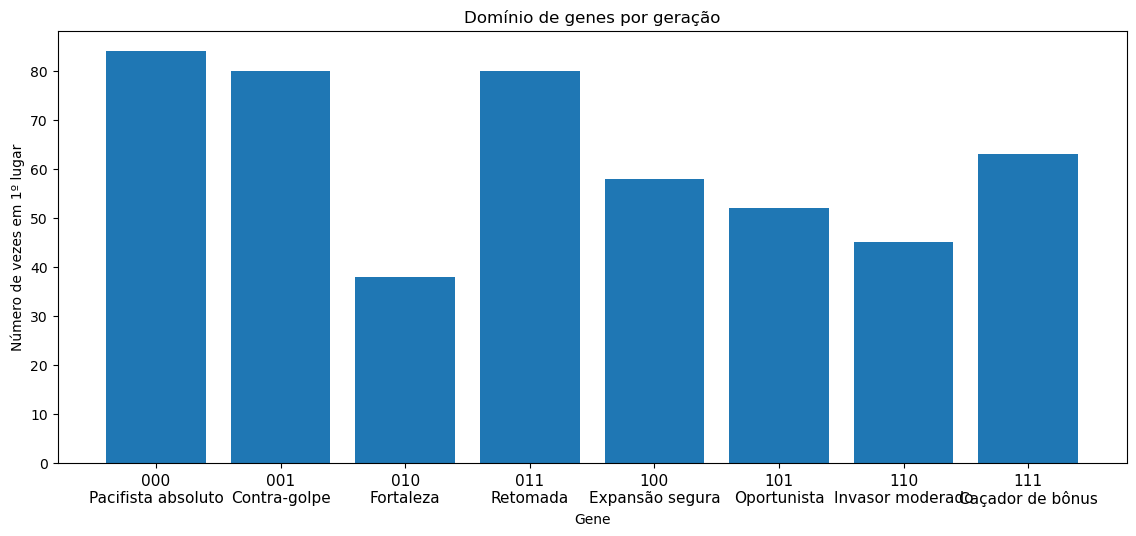

In [11]:
# 1. Conta o gene que ficou em 1º lugar em cada geração
vencedores = []
for geracao, populacao, elos in historico_evolutivo:
    idx = np.argmax(elos)
    vencedores.append(populacao[idx])

contagem = Counter(vencedores)
genes_possiveis = sorted(estrategias.keys())

# 2. Gera a lista de contagem para todos os genes (mesmo os que nunca venceram)
contagem_lista = [contagem.get(g, 0) for g in genes_possiveis]

# 3. Plota o gráfico
plt.figure(figsize=(12, 6))  # aumenta o tamanho do gráfico
plt.bar(genes_possiveis, contagem_lista)
plt.xlabel('Gene')
plt.ylabel('Número de vezes em 1º lugar')
plt.title('Domínio de genes por geração')
plt.xticks(
    genes_possiveis, 
    [f'{g}\n{estrategias[g]}' for g in genes_possiveis], 
    rotation=0,
    fontsize=11,           # aumenta a fonte do eixo x
    ha='center'            # centraliza
)
plt.tight_layout(pad=3)     # mais espaço ao redor
plt.show()



In [12]:
import random
from pprint import pprint

def gerar_tabuleiro_aleatorio(jogadores):
    random.shuffle(TERRITORIOS)
    distribuicao = {jogador: [] for jogador in jogadores}
    for i, terr in enumerate(TERRITORIOS):
        distribuicao[jogadores[i % len(jogadores)]].append(terr)
    return distribuicao

# Exemplo de uso
jogadores = ["Jogador 1", "Jogador 2", "Jogador 3"]
configuracao = gerar_tabuleiro_aleatorio(jogadores)
pprint(configuracao)


{'Jogador 1': ['Austrália',
               'México',
               'Dudinka',
               'Tchita',
               'Califórnia',
               'Vladivostok',
               'Vietnã',
               'Vancouver',
               'Peru',
               'Islândia',
               'Índia',
               'Japão',
               'Brasil',
               'Sibéria'],
 'Jogador 2': ['Alemanha',
               'Aral',
               'Alasca',
               'França',
               'Ottawa',
               'Groenlândia',
               'Moscou',
               'Congo',
               'Nova York',
               'Bornéu',
               'Venezuela',
               'Argélia',
               'Egito',
               'Labrador'],
 'Jogador 3': ['Inglaterra',
               'Polônia',
               'Madagascar',
               'Argentina',
               'Mongólia',
               'Mackenzie',
               'Suécia',
               'China',
               'África do Sul',
               'Sumatra